# Detect High Data Drift 
<b>With this tutorial you:</b><br />
Understand how to use Eurybia to detect datadrift

Contents:
- Detect data drift  
- Compile Drift over years

This public dataset comes from :

https://www.kaggle.com/sobhanmoosavi/us-accidents/version/10

---
Acknowledgements
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.
---

In this tutorial, the data are not loaded raw, a data preparation to facilitate the use of the tutorial has been done. You can find it here : 
https://github.com/MAIF/eurybia/blob/master/eurybia/data/dataprep_US_car_accidents.ipynb

In [3]:
import pandas as pd
from category_encoders import OrdinalEncoder
import catboost
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

## Import Dataset and split in training and production dataset

In [4]:
from eurybia.data.data_loader import data_loading

In [5]:
df_car_accident = data_loading("us_car_accident")

In [6]:
df_car_accident.head()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),day_of_week_acc,Nautical_Twilight,season_acc,target,target_multi,year_acc,Description
0,33.0,-117.1,0.0,40.0,93.0,2.0,3,Day,winter,0,2,2019,At Carmel Mountain Rd - Accident.
1,29.5,-98.5,0.0,83.0,65.0,10.0,4,Day,summer,1,3,2017,At TX-345-SP/Woodlawn Ave/Exit 567B - Accident.
2,32.7,-96.8,0.0,88.0,57.0,10.0,0,Night,summer,0,2,2021,Incident on RUGGED DR near BERKLEY AVE Expect ...
3,40.0,-76.3,0.0,61.0,58.0,10.0,4,Day,spring,0,2,2020,At PA-741/Rohrerstown Rd - Accident.
4,41.5,-81.8,1.0,71.0,53.0,10.0,0,Day,summer,0,2,2020,At 117th St/Exit 166 - Accident.


In [7]:
df_car_accident.shape

(50000, 13)

In [8]:
# Let us consider that the column "year_acc" corresponds to the reference date. 
#In 2016, a model was trained using data. And in next years, we want to detect data drift on new data in production to predict
df_accident_baseline = df_car_accident.loc[df_car_accident['year_acc'] == 2016]
df_accident_2017 = df_car_accident.loc[df_car_accident['year_acc'] == 2017]
df_accident_2018 = df_car_accident.loc[df_car_accident['year_acc'] == 2018]
df_accident_2019 = df_car_accident.loc[df_car_accident['year_acc'] == 2019]
df_accident_2020 = df_car_accident.loc[df_car_accident['year_acc'] == 2020]
df_accident_2021 = df_car_accident.loc[df_car_accident['year_acc'] == 2021]

In [9]:
#We will train a classification model to predict the severity of an accident. 0 for a less severe accident and 1 for a severe accident.
#Let's check percentage in class 0 and 1
pd.crosstab(df_car_accident.year_acc, df_car_accident.target, normalize = 'index')*100

target,0,1
year_acc,,
2016,71.406287,28.593713
2017,67.254620,32.745380
2018,66.634662,33.365338
2019,79.551182,20.448818
2020,89.944804,10.055196
2021,98.259930,1.740070


In [10]:
y_df_learning=df_accident_baseline['target'].to_frame()
X_df_learning=df_accident_baseline[df_accident_baseline.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2017=df_accident_2017['target'].to_frame()
X_df_2017=df_accident_2017[df_accident_2017.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2018=df_accident_2018['target'].to_frame()
X_df_2018=df_accident_2018[df_accident_2018.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2019=df_accident_2019['target'].to_frame()
X_df_2019=df_accident_2019[df_accident_2019.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2020=df_accident_2020['target'].to_frame()
X_df_2020=df_accident_2020[df_accident_2020.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2021=df_accident_2021['target'].to_frame()
X_df_2021=df_accident_2021[df_accident_2021.columns.difference(["target", "target_multi", "year_acc", "Description"])]

## Building Supervized Model

In [11]:
features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Visibility(mi)', 'day_of_week_acc', 'Nautical_Twilight',
       'season_acc']

In [12]:
features_to_encode = [col for col in X_df_learning[features].columns if X_df_learning[col].dtype not in ('float64','int64')]

encoder = OrdinalEncoder(cols=features_to_encode)
encoder = encoder.fit(X_df_learning[features])

X_df_learning_encoded=encoder.transform(X_df_learning)

In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df_learning_encoded, y_df_learning, train_size=0.75, random_state=1)

In [14]:
train_pool_cat = catboost.Pool(data=Xtrain, label= ytrain, cat_features = features_to_encode)
test_pool_cat = catboost.Pool(data=Xtest, label= ytest, cat_features = features_to_encode)

In [15]:
model = catboost.CatBoostClassifier(loss_function= "Logloss", eval_metric="Logloss",
                                    learning_rate=0.143852,
                                    iterations=150,
                                    l2_leaf_reg=15,
                                    max_depth = 4,
                                    use_best_model=True,
                                    custom_loss=['Accuracy', 'AUC', 'Logloss'])

model = model.fit(train_pool_cat, plot=True,eval_set=test_pool_cat)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6596523	test: 0.6580791	best: 0.6580791 (0)	total: 190ms	remaining: 28.3s
1:	learn: 0.6359865	test: 0.6338763	best: 0.6338763 (1)	total: 225ms	remaining: 16.7s
2:	learn: 0.6149589	test: 0.6116489	best: 0.6116489 (2)	total: 261ms	remaining: 12.8s
3:	learn: 0.6000164	test: 0.5959811	best: 0.5959811 (3)	total: 305ms	remaining: 11.1s
4:	learn: 0.5879103	test: 0.5831790	best: 0.5831790 (4)	total: 356ms	remaining: 10.3s
5:	learn: 0.5775840	test: 0.5726323	best: 0.5726323 (5)	total: 410ms	remaining: 9.84s
6:	learn: 0.5697851	test: 0.5639832	best: 0.5639832 (6)	total: 458ms	remaining: 9.35s
7:	learn: 0.5635665	test: 0.5576010	best: 0.5576010 (7)	total: 524ms	remaining: 9.31s
8:	learn: 0.5588859	test: 0.5524735	best: 0.5524735 (8)	total: 563ms	remaining: 8.82s
9:	learn: 0.5551827	test: 0.5484451	best: 0.5484451 (9)	total: 609ms	remaining: 8.53s
10:	learn: 0.5511320	test: 0.5440354	best: 0.5440354 (10)	total: 657ms	remaining: 8.3s
11:	learn: 0.5472423	test: 0.5397257	best: 0.5397257 

In [16]:
proba = model.predict_proba(Xtest)
print(metrics.roc_auc_score(ytest,proba[:,1]))

0.7634385095163502


## Use Eurybia for data validation

In [17]:
from eurybia import SmartDrift

In [18]:
SD = SmartDrift(df_current=X_df_2017, df_baseline=X_df_learning, deployed_model=model, encoding=encoder)

In [19]:
%time SD.compile(full_validation=True, date_compile_auc = '01/01/2017', datadrift_file = "car_accident_auc.csv")
                 

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.6585689489728102
CPU times: total: 1min 16s
Wall time: 24.3 s


As soon as compile() method, Eurybia displays default consistency checks as warnings.<br />
If some modalities are not present during training and are in production dataset, the deployed model will consider them wrongly.<br />
Inversely, if some modalities are present during training and are not in production dataset, it means that some profiles are missing.

In [20]:
SD.generate_report(    
    output_file='report_car_accident_datadrift_2017.html',    
    title_story="Data drift",
    title_description="""Car accident Data drift 2017""",
    project_info_file="../../../../eurybia/data/project_info_car_accident.yml"  
    )

Report saved to ./report_car_accident_datadrift_2017.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Eurybia is designed to generate an HTML report for analysis, and less for use in notebook mode. 
However, to illustrate functionalities, we will detail results with notebook mode analysis.

## First Analysis of results of the data drift

Data driftn methodology is based on the ability of a model to discriminate whether an individual belongs to one of the two datasets.
For this purpose a target 0 is assigned to the baseline dataset and a target 1 to the current dataset.
Then a classification model (catboost) is learned to predict this target.
The level of capacity of the data drift classifier to detect if an individual belongs to one of the 2 datasets represents the level of difference between the 2 datasets

### Detection data drift performance

In [21]:
#Performance of data drift classifier
SD.auc

0.6585689489728102

An Auc close to 0.5 means that there is little drift

### Importance of features in data drift

This graph represents the variables in the data drift classification model that are most important to differentiate between the two datasets.

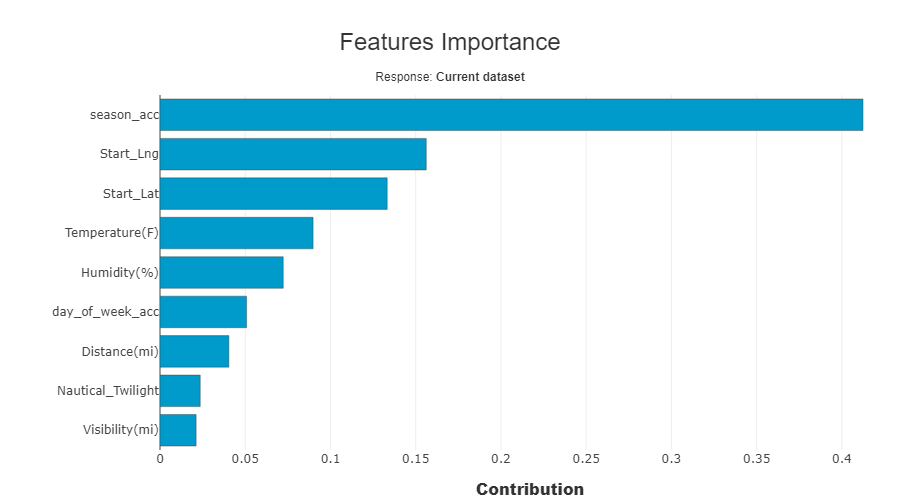

In [22]:
SD.xpl.plot.features_importance()

We get the features with most gaps, those that are most important to analyse.
With date bias introduced, it is normal that date features are the most impacted. We will then decide to remove them.
Let's analyse other important variables

### Feature importance overview

This graph compares the importance of variables between the data drift classifier model and the deployed model. This allows us to put into perspective the importance of data drift in relation to the impacts to be expected on the deployed model. If the variable is at the top left, it means that the variable is very important for data drift classification, but that the variable has little influence on the deployed model. If the variable is at the bottom right, it means that the variable has little importance for data drift classification, and that the variable has a lot of influence on the deployed model.

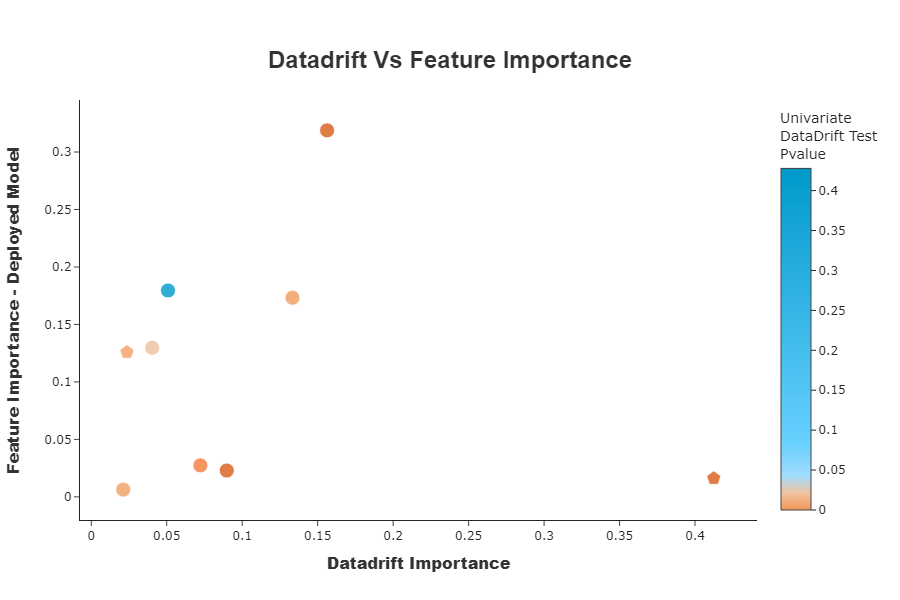

In [23]:
SD.plot.scatter_feature_importance()

Putting importance of the drift into perspective according to the importance of the model to be deployed, can help the data scientist to validate that his model can be deployed. <br />


### Univariate analysis

This graphs shows a particular feature's distribution over its possible values. In the drop-down menu, the variables are sorted by importance of the variables in the data drift classification. For categorical features, the possible values are sorted by descending difference between the two datasets.

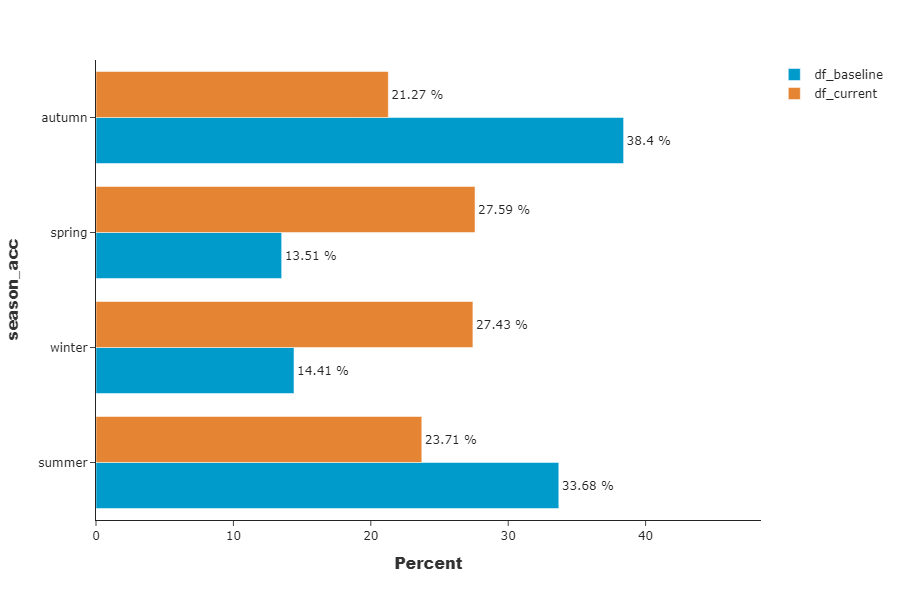

In [24]:
SD.plot.generate_fig_univariate('season_acc')

### Distribution of predicted values

This graph shows distributions of the production model outputs on both baseline and current datasets.

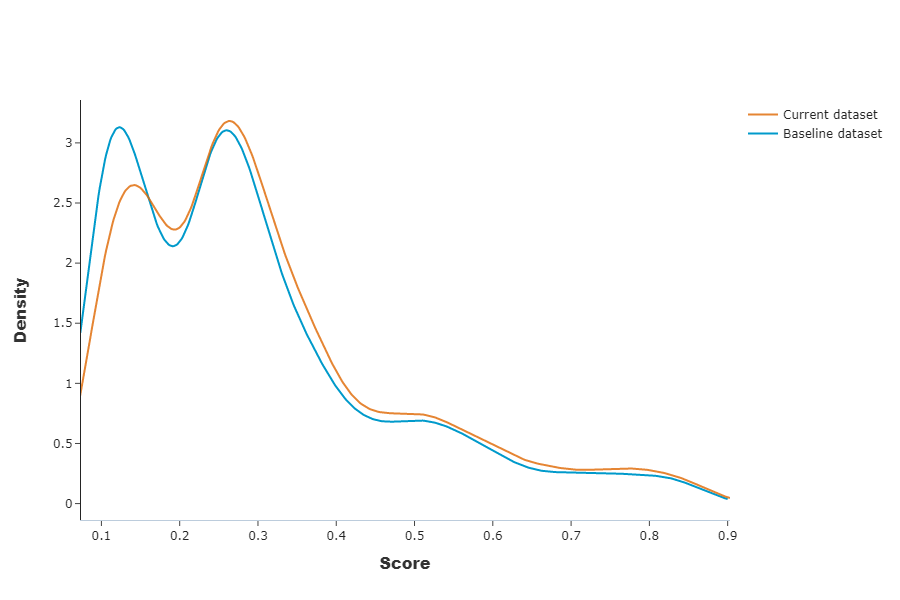

In [25]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset")

## Compile Drift over years

### Compile Drift et generate report for Year 2018

In [26]:
SD = SmartDrift(df_current=X_df_2018, df_baseline=X_df_learning, deployed_model=model, encoding=encoder)

In [27]:
SD.compile(full_validation=True,
           date_compile_auc = '01/01/2018', #optionnal, by default date of compile
           datadrift_file = "car_accident_auc.csv"
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7036329129677259


----

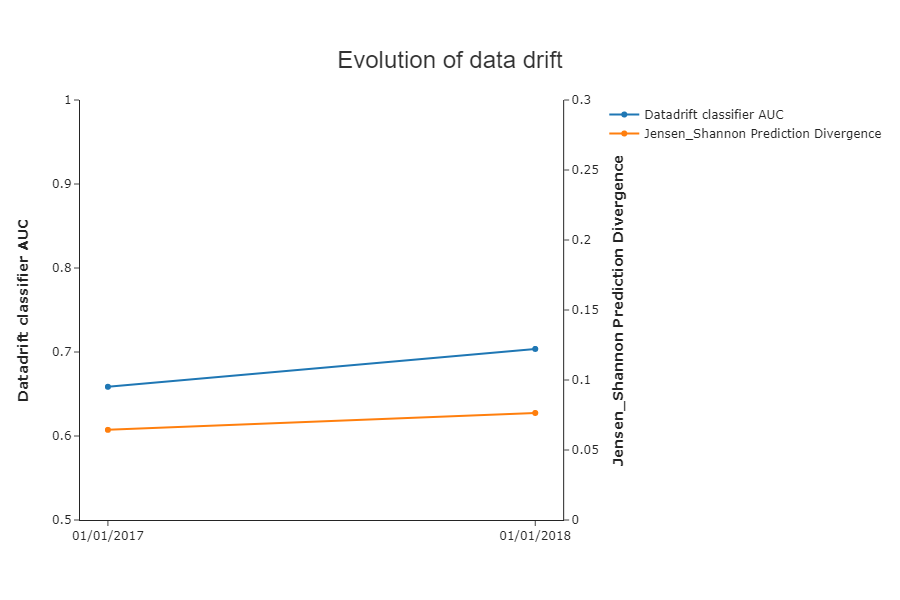

In [28]:
SD.plot.generate_historical_datadrift_metric()

------

### Compile Drift et generate report for Year 2019

In [29]:
SD = SmartDrift(df_current=X_df_2019, df_baseline=X_df_learning, deployed_model=model, encoding=encoder)

In [30]:
SD.compile(full_validation=True,
           date_compile_auc = '01/01/2019', #optionnal, by default date of compile
           datadrift_file = "car_accident_auc.csv"
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7856527709300022


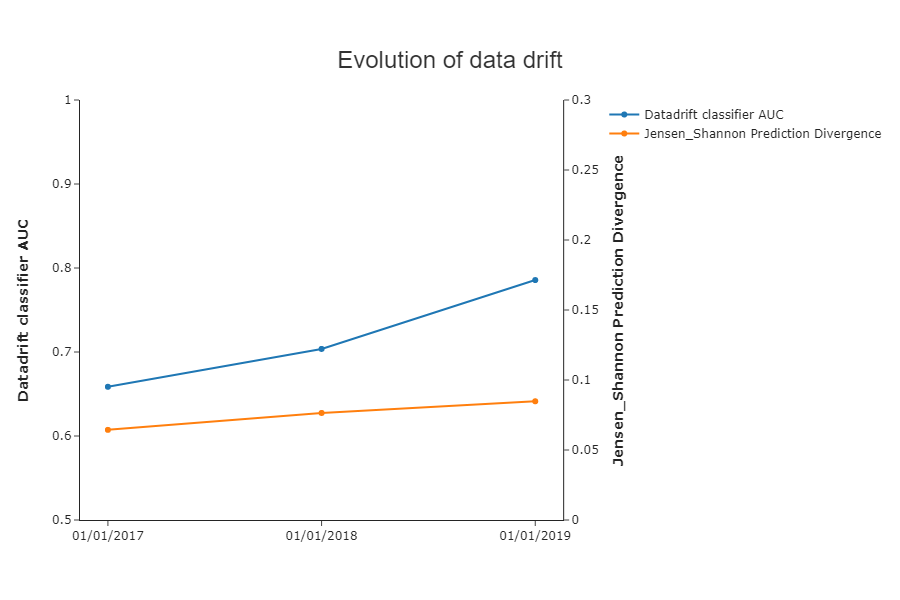

In [31]:
SD.plot.generate_historical_datadrift_metric()

### Compile Drift et generate report for Year 2020

In [32]:
SD = SmartDrift(df_current=X_df_2020, df_baseline=X_df_learning, deployed_model=model, encoding=encoder)

In [33]:
SD.compile(full_validation=True,
           date_compile_auc = '01/01/2020', #optionnal, by default date of compile
           datadrift_file = "car_accident_auc.csv"
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7902450838961592


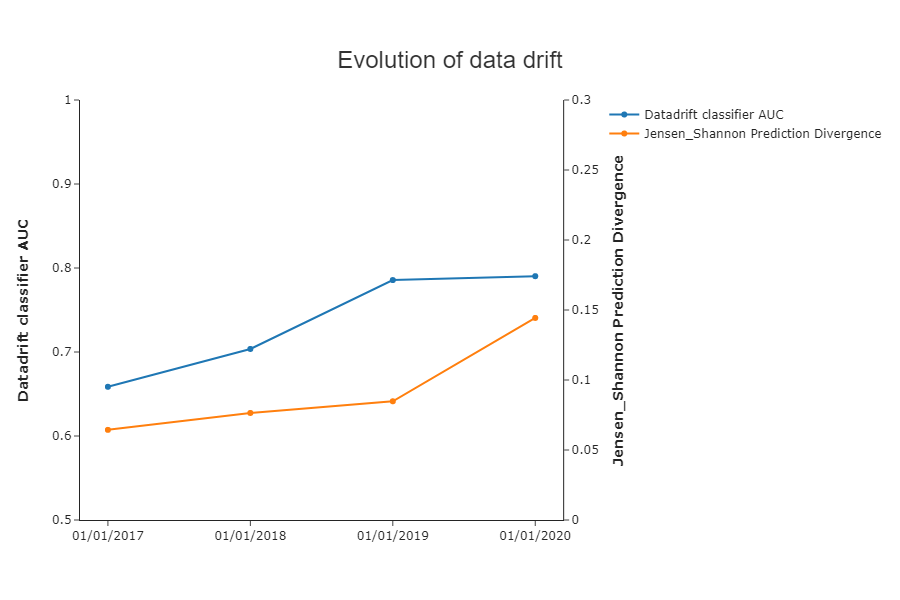

In [34]:
SD.plot.generate_historical_datadrift_metric()

### Compile Drift et generate report for Year 2021

In [35]:
SD = SmartDrift(df_current=X_df_2021, df_baseline=X_df_learning, deployed_model=model, encoding=encoder)

In [36]:
SD.compile(full_validation=True,
           date_compile_auc = '01/01/2021', #optionnal, by default date of compile
           datadrift_file = "car_accident_auc.csv"
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7500011519622525


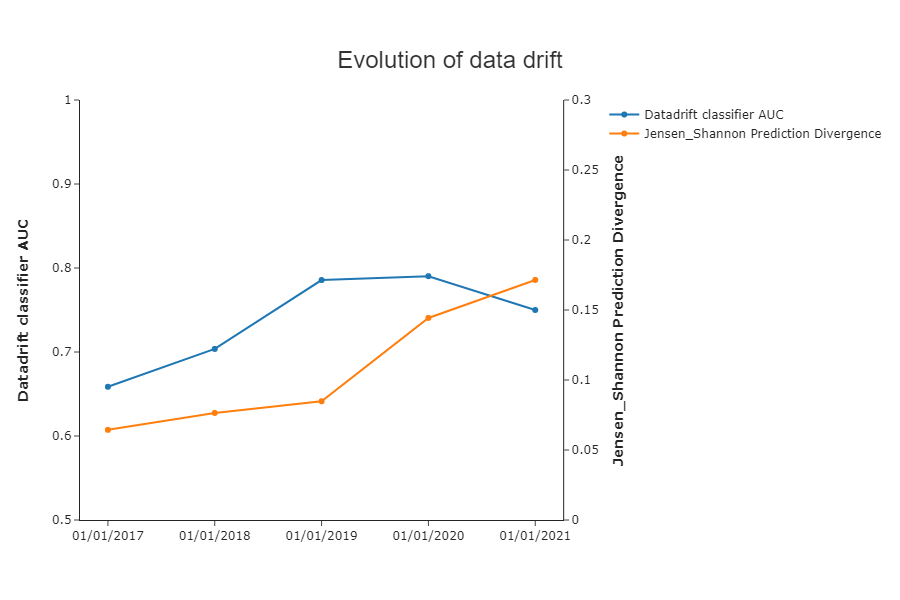

In [37]:
SD.plot.generate_historical_datadrift_metric()

In [38]:
SD.generate_report(    
    output_file='report_car_accident_datadrift_2020.html',    
    title_story="Data drift",
    title_description="""Car accident Data drift 2020""",
    project_info_file="../../../../eurybia/data/project_info_car_accident.yml"    
    )

Report saved to ./report_car_accident_datadrift_2020.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.